In [2]:
#라이브러리 호출
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%pip install torch
import torch
import torch.nn as nn
from torch.autograd import Variable

%pip install torchvision
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
#CPU 혹은 GPU 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
#fashion_mnist 데이터셋 다운로드하기
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor()]
    )
    
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                        download=True, transform=transform)
                                        
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                        download=True, transform=transform)

#torchvision.datasets는 torch.utils.data.Dataset의 하위 클래스로 다양한 데이터셋(CIFAR, COCO, MNIST, ImageNet 등)을 포함합니다.
#< torchvision.datasets 파라미터 >
#root: FashionMNIST 데이터셋이 저장될 경로입니다. 지정한 경로가 없으면 새로 생성됩니다.
#train=True: 학습용 데이터를 다운로드합니다.
#download=True: "데이터셋이 저장될 경로"에 데이터셋이 있는지 확인한 후 없는 경우 다운로드됩니다.
#transform=trainsform: 입력된 이미지 데이터를 텐서(0~1) 형태로 변경합니다.


100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
#fashion_mnist 데이터를 데이터로더에 전달
#다운로드한 fashion_mnist 데이터를 일정한 batch size로 묶어서  데이터로더(DataLoader)를 만들어주는 코드입니다.
train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=100, 
    shuffle=True
)
#torch.utils.data.DataLoader()를 사용하여 원하는 크기의 배치 단위로 데이터를 불러오거나, 순서가 무작위로 섞이도록 할 수 있습니다.
test_loader = torch.utils.data.DataLoader(
    testset, 
    batch_size=100, 
    shuffle=False
)
#< DataLoader 파라미터 >

#trainset : 데이터를 불러올 데이터셋을 지정합니다.
#batch_size : 데이터를 배치로 묶어줍니다. 100개 단위로 묶어줍니다.
#shuffle : 데이터를 불러올 때마다 데이터를 섞어서 불러옵니다. 

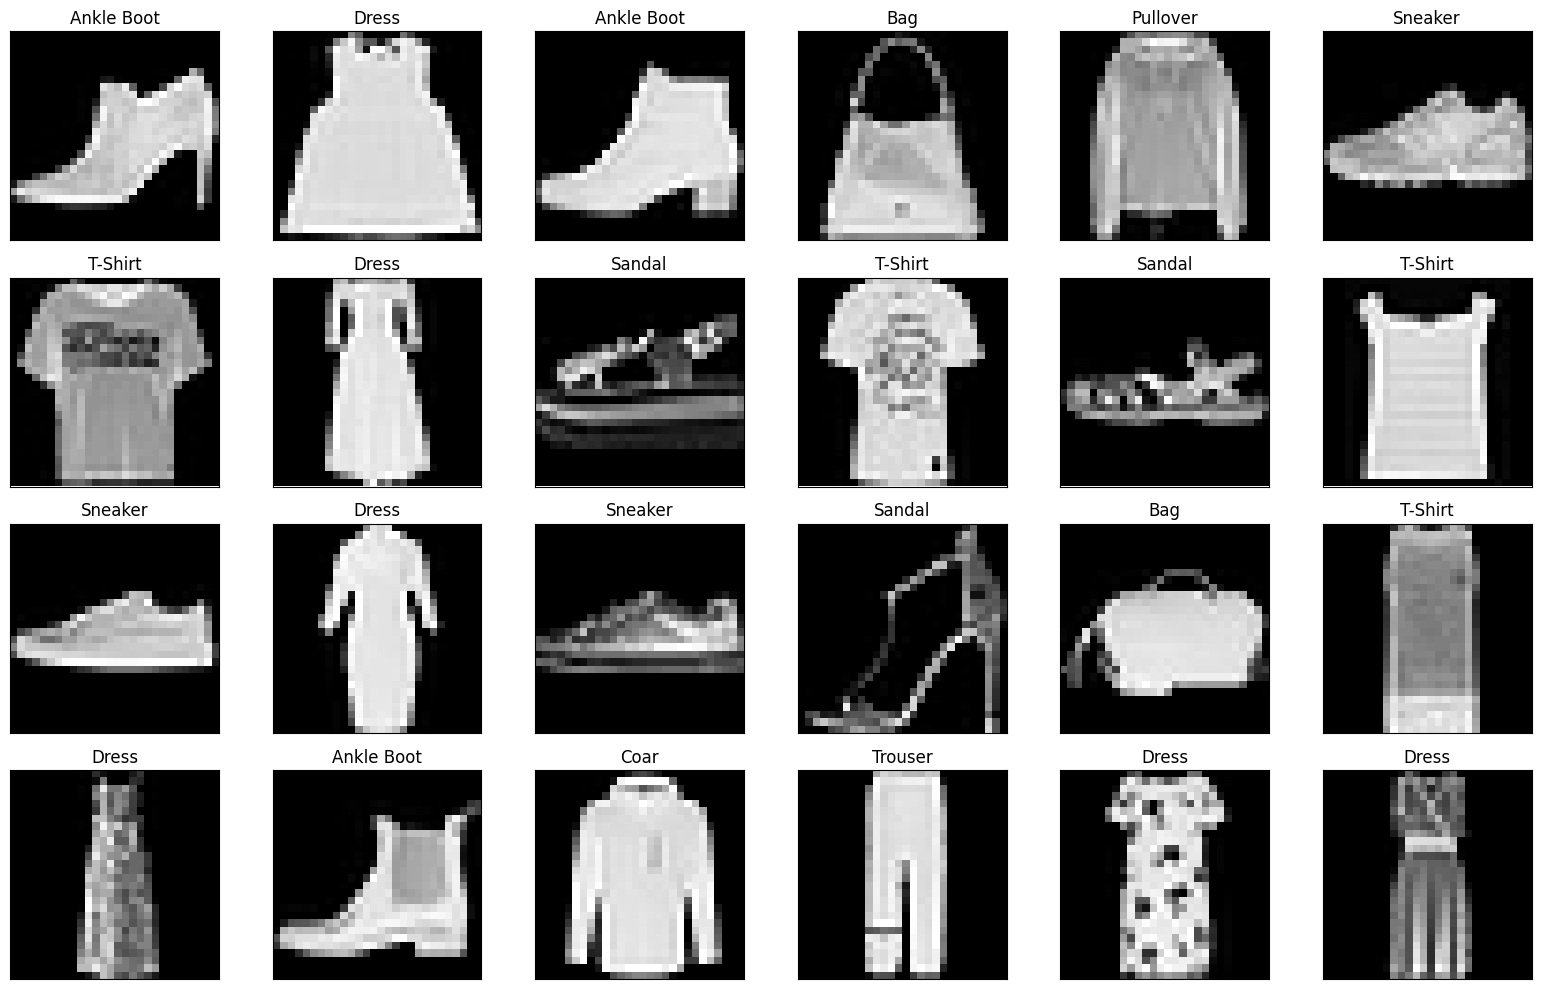

In [6]:
#분류에 사용될 클래스 정의 
import matplotlib.pyplot as plt
import numpy as np
#FashionMNIST 데이터셋으로부터 랜덤으로 24개의 샘플 이미지와 라벨을 가져와서 시각화하는 코드입니다.
#DataLoader에서 shuffle=True로 설정되어 있기 때문에 매 epoch마다 데이터가 랜덤하게 섞입니다.
#next(iter(train_loader))를 호출할 때마다 다른 미니배치가 반환됩니다.

# train_loader 에서 첫 번째 배치를 가져와 이미지와 라벨을 sample, labels에 저장
samples, labels = next(iter(train_loader))

# 각 클래스의 이름을 숫자와 매칭하여 저장 (총 10개)
classes = {0:'T-Shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coar',
5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(16, 10)) # 4행 6열의 서브플롯을 생성

for ax, image, label in zip(axs.flatten(), samples, labels):
    image = np.transpose(image.numpy(), (1, 2, 0)) # 차원 변환: (C, H, W) -> (H, W, C)
    
    ax.imshow(image, cmap='gray') # 흑백 이미지로 출력
    ax.set_title(classes[label.item()], fontsize=12) # label.item(): torch.Tensor 타입의 스칼라 값(정수)을 얻기 위해 사용
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.show()
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]


In [7]:
#합성곱(CNN) 네트워크 생성
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential( ## 1 nn.Sequential은 PyTorch에서 제공하는 클래스로, 여러 개의 neural network layer들을 연속적으로 실행하는 기능을 제공합니다.
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), ## 2합성곱층은 이미지의 특징을 추출하는 데 사용됩니다. 이를 위해 커널(필터)이라는 n*m 크기의 행렬을 사용하여 이미지를 처음부터 끝까지 훑습니다. 
            nn.BatchNorm2d(32), ## 3nn.BatchNorm2d은 배치 정규화를 수행하는 클래스입니다. 이를 사용하여 딥러닝 모델에서 과적합 문제나 gradient vanishing/exploding 문제를 해결할 수 있습니다.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) ## 4 MaxPool2d는 입력 데이터의 최댓값을 출력하는 연산이며, 이미지 크기를 축소시키는 용도로 사용합니다.
        )
       
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600) ## 5 이미지 데이터를 분류하기 위해서는 배열 형태로 변환하여 처리해야 합니다.
        self.drop=nn.Dropout(0.25)
        self.fc2=nn.Linear(in_features=600, out_features=120)
        self.fc3=nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) ## 6 합성곱층에서 완전연결층으로 변경되기 때문에 데이터의 형태를 1차원으로 바꿔주는 작업이 필요합니다. 이때 out.size(0)은 결국 100을 의미합니다.
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


In [8]:
# 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# 모델을 학습시키지 전에 손실함수, 학습률, 옵티마이저에 대해 정의합니다.
# 옵티마이저를 위한 경사 하강법은 Adam을 사용하며, 학습률을 의미하는 lr은 0.001을 사용한다는 의미입니다.

In [9]:
# 모델 학습 및 성능 평가
num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs): # 100개의 이미지와 레이블이 하나의 배치로 묶여서 가져옴
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train) # 학습 데이터(batch)를 모델에 입력하여 출력값 계산
        loss = criterion(outputs, labels) # 손실값 계산
        optimizer.zero_grad()  # 이전에 계산된 그래디언트 값 초기화
        loss.backward()        # 손실에 대한 그래디언트 계산
        optimizer.step()       # 계산된 그래디언트를 이용하여 가중치 업데이트
        count += 1
        
        if (count % 50)==0: #  매 50번째 iteration마다 test data를 이용해 accuracy를 계산
            total = 0
            correct = 0

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                labels_list.append(labels)
                test = Variable(images.view(-1, 1, 28, 28))
                
                outputs = model(test)
                predictions = torch.argmax(outputs, 1).to(device) # 최댓값의 위치
                predictions_list.append(predictions)
                
                correct += (predictions == labels).sum() # 정답을 맞춘 데이터의 수
                total += len(labels) # 총 데이터의 수
        
            accuracy = correct / total * 100 # 정확도
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
                
        if (count % 500)==0:
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, 
                accuracy))


# Autograd는 자동 미분을 수행하는 파이토치의 패키지입니다. Autograd는 Variable을 사용해서 역전파를 위한 미분 값을 자동으로 계산해 줍니다. Variable은 PyTorch에서 기존의 tensor를 감싸서 미분 가능한 tensor로 만드는 역할을 합니다.
#이것은 주어진 입력에 대한 기울기(gradient)를 자동으로 계산하기 위한 것입니다. 



Iteration: 500, Loss: 0.43851497769355774, Accuracy: 87.75%
Iteration: 1000, Loss: 0.22195939719676971, Accuracy: 88.63999938964844%
Iteration: 1500, Loss: 0.35120946168899536, Accuracy: 89.6500015258789%
Iteration: 2000, Loss: 0.11655009537935257, Accuracy: 89.94000244140625%
Iteration: 2500, Loss: 0.1736113578081131, Accuracy: 90.16000366210938%
Iteration: 3000, Loss: 0.0987529382109642, Accuracy: 89.72000122070312%


In [10]:
#FashionMNIST 데이터세트의 각 클래스에서 정확도 살펴보기
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 89.30%
Accuracy of Trouser: 98.50%
Accuracy of Pullover: 84.00%
Accuracy of Dress: 78.80%
Accuracy of Coat: 95.60%
Accuracy of Sandal: 96.40%
Accuracy of Shirt: 61.60%
Accuracy of Sneaker: 98.10%
Accuracy of Bag: 98.30%
Accuracy of Ankle Boot: 96.30%


In [11]:
# Printing the Confusion Matrix
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [12]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.83      0.84      0.83     60000
           1       0.98      0.98      0.98     60000
           2       0.81      0.83      0.82     60000
           3       0.89      0.88      0.88     60000
           4       0.78      0.84      0.81     60000
           5       0.98      0.97      0.97     60000
           6       0.70      0.64      0.67     60000
           7       0.93      0.95      0.94     60000
           8       0.97      0.97      0.97     60000
           9       0.95      0.95      0.95     60000

    accuracy                           0.88    600000
   macro avg       0.88      0.88      0.88    600000
weighted avg       0.88      0.88      0.88    600000


